In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
import math
import statistics
pd.set_option('display.max_rows', 10000)
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import the data
# NOTE: may have to get rid of engine parameter for it to run
stock_data = pd.read_excel('csds442_data2.xlsx', engine='openpyxl')
stock_data.columns =  ['Symbol','Treated', 'CompanyName', 'MarketCap','ShortPercent', 'Sector', 'TrailingEPS', 'Nov2020', 'Jan2021', 'BeforeTreatment', 'AfterTreatment']

# derive a couple new columns from the data
stock_data['PriorThreeMonths'] = (stock_data['Jan2021'] - stock_data['Nov2020'])/stock_data['Nov2020']
stock_data['TreatmentChange'] = 100*((stock_data['AfterTreatment'] - stock_data['BeforeTreatment'])/stock_data['BeforeTreatment'])

# add mention column that specifies the number of mentions the stock has based on SwaggyStocks data
stock_data['Mentions'] = np.nan
mention_set = pd.read_csv('swaggy_data.csv')
for i in range(len(stock_data)):
    if stock_data['Symbol'].iloc[i] in list(mention_set['tk']):
        stock_data['Mentions'].iloc[i] = int(mention_set[mention_set['tk'] == stock_data['Symbol'].iloc[i]]['ment'].iloc[0])
        
t = stock_data[stock_data['Treated']==1]
nt = stock_data[stock_data['Treated']==0]
random_sel = nt.sample(300)
frames = [t, random_sel]
stock_data = pd.concat(frames)

dummies = pd.get_dummies(stock_data['Sector'], drop_first=True)
stock_data = pd.concat([stock_data, dummies], axis=1)

/home/ctt0/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
# run linear regression on the treated values
model = LinearRegression()
treated = stock_data[stock_data['Treated'] == 1]
X_treatment =np.array(list(treated['Mentions'])).reshape(-1, 1)
y_result = np.array(list(treated['TreatmentChange'])).reshape(-1, 1)
model.fit(X_treatment, y_result)

beta_0 = model.intercept_[0]
beta_1 = model.coef_[0][0]

In [4]:
result_mention = 'Beta_0 = ' + str(round(beta_0,3)) + ' and Beta_1 = ' + str(round(beta_1,3))

Text(0, 0.5, 'Residual of Regression')

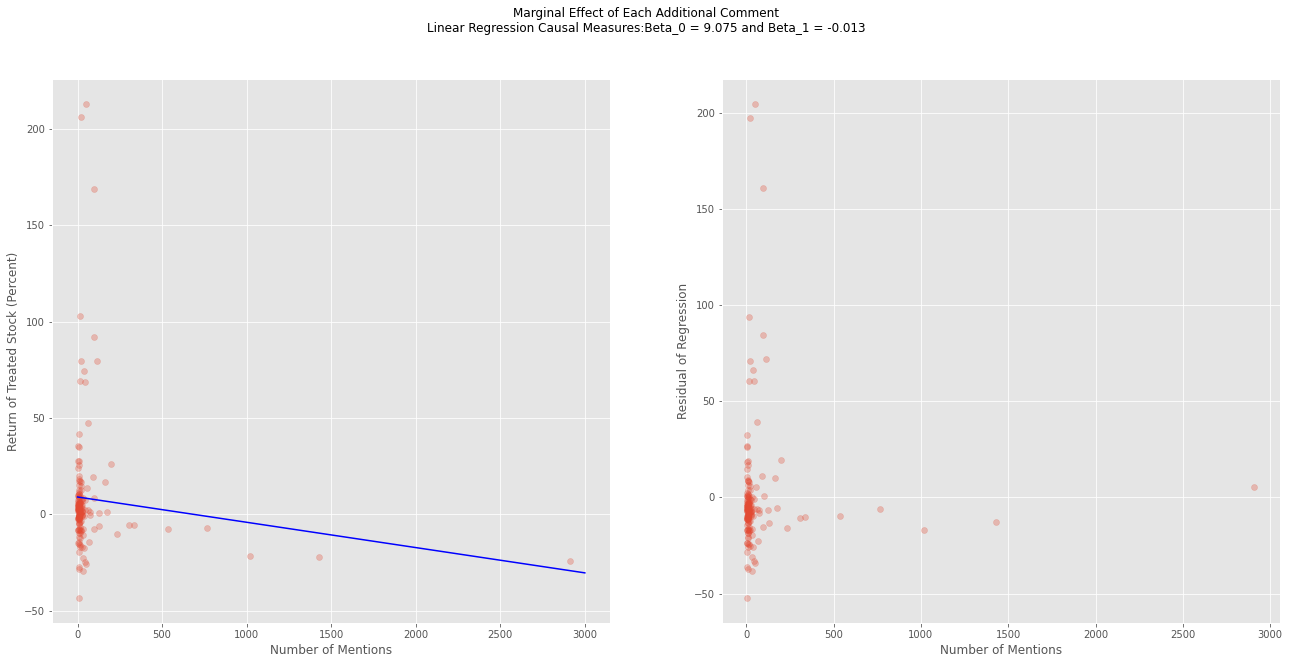

In [5]:
# plot the marginal effect of each additional mention
plt.figure()
fig = plt.gcf()
fig.set_size_inches(22, 10)
fig.suptitle('Marginal Effect of Each Additional Comment\nLinear Regression Causal Measures:' + result_mention)

plt.subplot(1,2,1)
plt.scatter(treated['Mentions'], treated['TreatmentChange'], alpha = .3)

mention_space = np.linspace(0,3000,5)
exp_y = beta_0 + beta_1 * mention_space
plt.plot(mention_space, exp_y, color ='b')

plt.xlabel('Number of Mentions')
plt.ylabel('Return of Treated Stock (Percent)')

# plot the residual of regression

plt.subplot(1,2,2)

residual = []
for i in range(len(treated)):
    res = treated['TreatmentChange'].iloc[i] - (treated['Mentions'].iloc[i] * beta_1 + beta_0)
    residual.append(res)
    
plt.scatter(treated['Mentions'], residual, alpha = .3)
    
plt.xlabel('Number of Mentions')
plt.ylabel('Residual of Regression')

In [6]:
# function to sample an input number of times to get multiple causal effect measure values
def bootstrap_standard(dataframe, run_count):
    
    # sample should be same size as input data set
    sample_size = dataframe.shape[0]
    alpha_0_list = []
    alpha_1_list = []
    for i in range(run_count):
        
        # draw new sample with replacement
        sample = dataframe.sample(sample_size, replace=True)
        
        model = LinearRegression()     
        
        # run linear regression on sample, where we use weights if parameter ipw is true and do not otherwise
        X_treatment =np.array(list(sample['Mentions'])).reshape(-1, 1)
        y_result = np.array(list(sample['TreatmentChange'])).reshape(-1, 1)
        
        model.fit(X_treatment, y_result)
        
        alpha_0_list.append(model.intercept_[0])
        alpha_1_list.append(model.coef_[0][0])
        
    return(alpha_0_list, alpha_1_list)

In [7]:
# generate 1000 samples using bootstrapping
alpha_0, alpha_1 = bootstrap_standard(treated,1000)
b0_se = statistics.stdev(alpha_0)
b1_se = statistics.stdev(alpha_1)
se_orig = 'Beta_0 SE = ' + str(round(b0_se,3)) + ' and Beta_1 = ' + str(round(b1_se,3))
confidence = 'Beta_0: (' + str(round(beta_0 - b0_se,3)) + ',' + str(round(beta_0 + b0_se,3)) + ') and Beta_1 (' + str(round(beta_1 - b1_se,3)) + ',' + str(round(beta_1 + b1_se,3)) +')'

(-0.05, 0.15)

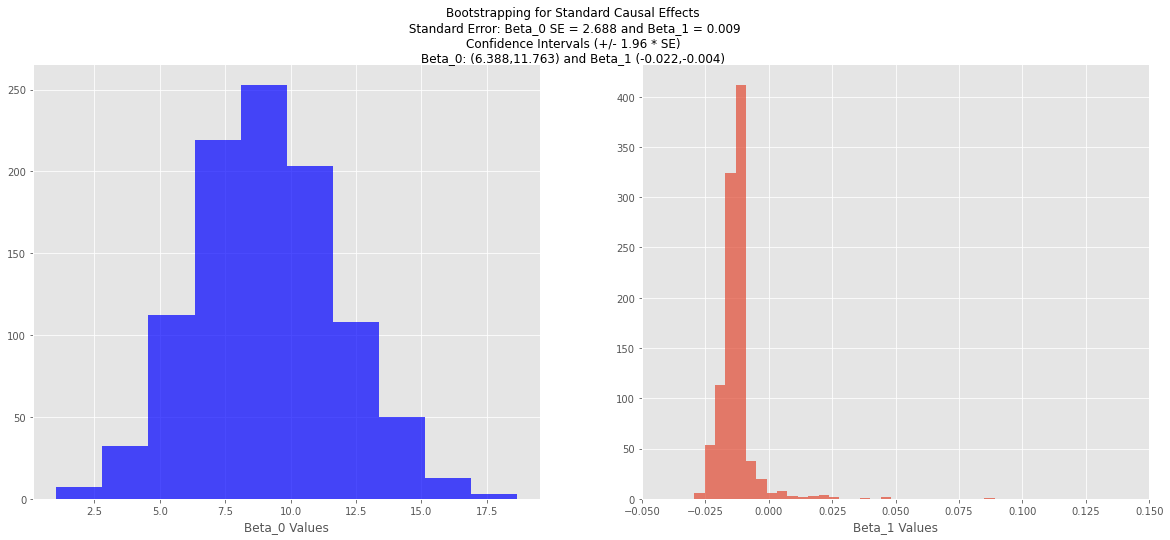

In [8]:
# plot the beta_0 and beta_1 values for all samples
plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 8)

fig.suptitle('Bootstrapping for Standard Causal Effects\n Standard Error: ' + se_orig + '\nConfidence Intervals (+/- 1.96 * SE)\n'+ confidence)

plt.subplot(1,2,1)
plt.xlabel('Beta_0 Values')
plt.hist(alpha_0, alpha= .7, color = 'b')

plt.subplot(1,2,2)
plt.xlabel('Beta_1 Values')
plt.hist(alpha_1, alpha = .7, bins = 50)
plt.xlim(-.05,.15)